# **IMPORTS**

In [1]:
%cd /content/
%ls
!pip install --upgrade --no-cache-dir gdown
!git clone https://github.com/ultralytics/yolov5.git  # Cloning the repo 
!gdown 10FTRA1EBIbENR579vdam8CNPA0Zw5PMB                  # Downloading the weights
!gdown --id 14Q35mg5itf05EnK0bT2py5NBPHnNazaM
!pip install -r ./yolov5/requirements.txt         # Installing the requirements


### SEGMENTATION IMPORTS

import yolov5.segment.predict as predict
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import subprocess
import matplotlib.pyplot as plt
import timeit
import time
import torch
%matplotlib inline

#disable yolov5 logging
import logging
logging.getLogger('yolov5').setLevel(logging.WARN)


### DETECTION YOLO IMPORTS
import argparse
import os
import platform
import sys
from pathlib import Path
import torch

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams
from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, smart_inference_mode

### OCR IMPORTS
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
!pip3 install -r ./PaddleOCR/requirements.txt
!pip install Polygon3
!pip install paddlepaddle
from PaddleOCR import PaddleOCR,draw_ocr
ocr = PaddleOCR(use_angle_cls=True, lang='en')

#disable paddleOCR logging
import logging 
logging.getLogger('ppocr').setLevel(logging.WARN)

/content
sample_data/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Cloning into 'yolov5'...
remote: Enumerating objects: 15070, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 15070 (delta 25), reused 29 (delta 12), pack-reused 15019
Receiving objects: 100% (15070/15070), 14.07 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (10324/10324), done.
Downloading...
From: https://drive.google.com/uc?id=10FTRA1EBIbENR579vdam8CNPA0Zw5PMB
To: /content/best.pt
100% 4.04M/4.04M [00:00<00:00, 94.4MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From:

100%|██████████| 4.00M/4.00M [00:17<00:00, 234kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:18<00:00, 542kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:15<00:00, 143kiB/s]

[2023/02/07 17:12:42] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set

# Segmentation + Warping
All the segmentation related functions are in this section

In [2]:
# Helper functions

def plotim(im_list, title_list):  # To plot a list of images and their titles
  import math
  nrows = math.ceil(len(im_list)/3)
  fig, ax = plt.subplots(nrows, 3, figsize=(nrows*30, 50))
  if nrows==1:
    for i in range(len(im_list)):
      ax[i%3].imshow(im_list[i])
      ax[i%3].set_title(title_list[i], size=22)
  else:
    for i in range(len(im_list)):
      ax[i//3, i%3].imshow(im_list[i])
      ax[i//3, i%3].set_title(title_list[i], size=22)
  plt.show()   


def importimage(filename):#import the image    
  image=cv2.imread(filename)
  # print(widt,heigt)
  return image 

def runInferencenew(filename,input_dir):
  op=predict.run(weights='/content/best.pt',save_txt=True,source=filename,exist_ok=True,nosave=True)
  #print(op)
  return op

def getmbox(filename,image,input_dir):     #get all mask boundary points
  file_ext = os.path.splitext(filename)[1]
  basename = str(os.path.basename(filename))
  bbox=list()
  try:
    with open('/content/yolov5/runs/predict-seg/exp/labels/'+ basename.rstrip(file_ext) +'.txt') as f:
      fl=0
      t=[]
      for x in next(f).split():       #reading file
        if fl==0:
          fl+=1
          continue
        if fl%2==0:
          t.append(float(x)*image.shape[0])
          bbox.append(t.copy())
        else:
          t.append(float(x)*image.shape[1])
        if(fl%2==0):
          t.clear()
        fl+=1
  except:
     bbox = [[0,0], [image.shape[0], 0], [image.shape[0], image.shape[1]], [0, image.shape[1]]]
  return bbox 

def dis2(c,d):
  return c*c+d*d

def getcorners2(filename,image,mbox):       #opencv corner coordinate function
  nim2=np.zeros((image.shape[0],image.shape[1],image.shape[2]))
  nim=cv2.fillConvexPoly(nim2.copy(),np.array(mbox,np.int32),color=(255,255,255))
  img=nim
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
  blurred = cv2.bilateralFilter(gray, 9, 75, 75)                          #smoothes out the noise in the image
  _, thresh = cv2.threshold(np.uint8(blurred), 0, 255, cv2.THRESH_OTSU)   #automatic image thresholding

  contours, _ = cv2.findContours(np.uint8(blurred), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour = contours[0]

  perimeter = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)

  dmin=10000000000
  ireq=-1
  for i in range(4):
    if dis2(approx[i][0][0],approx[i][0][1])<dmin:
      ireq=i
      dmin=dis2(approx[i][0][0],approx[i][0][1])
  return [approx[ireq][0],approx[(ireq-1+4)%4][0],approx[(ireq-2+4)%4][0],approx[(ireq-3+4)%4][0]]

def warpimage(image,corners):        #apply warping to the image
  cornersp = np.float32([corners[0], corners[1], corners[2], corners[3]])
  width, height = image.shape[1],image.shape[0]
  pts2 = np.float32([[0,0],[width,0],[width,height],[0,height]])
  matrix = cv2.getPerspectiveTransform(cornersp,pts2)
  output = cv2.warpPerspective(image,matrix,(width,height))
  return output

def runsegmentation(filenames,input_dir):      #aggregate function of all the above
  t=0
  outputArray = []
  for filename in filenames:
    try:
      image = importimage(filename)
      timetaken=runInferencenew(filename,input_dir)
      mbox=getmbox(filename,image,input_dir)
      seg_img = cv2.polylines(image.copy(),np.array([mbox],np.int32),isClosed=True,color=(255,255,0),thickness=3)
      coords=getcorners2(filename,image,mbox)  #openCV corner function
      final=warpimage(image,coords)
      cv2.imwrite('/content/'+  (filename[len(input_dir):]).split('.')[0] + 'sw.jpg'   ,final)
      outputArray.append((final, seg_img))
    except Exception:
      continue
  return outputArray

# YOLO prediction function


In [3]:
def detect(                                  # the function for inferring
        detectionModel, 
        source='data/images',  # file/dir/URL/glob/screen/0(webcam)
        data='data/coco128.yaml',  # dataset.yaml path
        imgsz=(640, 640),  # inference size (height, width)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        view_img=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        nosave=True,  # do not save images/videos
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project='/content/yolov5/runs/detect',  # save results to project/name
        name='expk',  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=3,  # bounding box thickness (pixels)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        half=False,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        vid_stride=1,  # video frame-rate stride
        printResult=True

):
    source = str(source)
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
    webcam = source.isnumeric() or source.endswith('.streams') or (is_url and not is_file)
    screenshot = source.lower().startswith('screen')
    if is_url and is_file:
        source = check_file(source)  # download

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    model = detectionModel
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size
    resultFound = dict()
    # Dataloader
    bs = 1  # batch_size
    if webcam:
        view_img = check_imshow(warn=True)
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
        bs = len(dataset)
    elif screenshot:
        dataset = LoadScreenshots(source, img_size=imgsz, stride=stride, auto=pt)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
    seen, windows, dt = 0, [], (Profile(), Profile(), Profile())
    for path, im, im0s, vid_cap, s in dataset:
        with dt[0]:
            im = torch.from_numpy(im).to(model.device)
            im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim

        # Inference
        with dt[1]:
            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred = model(im, augment=augment, visualize=visualize)

        # NMS
        with dt[2]:
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

        # Second-stage classifier (optional)
        # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)

        # Process predictions
        for i, det in enumerate(pred):  # per image
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f'{i}: '
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # im.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
            s += '%gx%g ' % im.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, 5].unique():
                    n = (det[:, 5] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if printResult:
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        # print(xywh)
                        if(int(cls) not in resultFound.keys()):
                          resultFound[int(cls)]=[]
                          resultFound[int(cls)].append([xywh, float(conf)])
                        else:
                          resultFound[int(cls)].append([xywh, float(conf)])
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(f'{txt_path}.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        annotator.box_label(xyxy, label, color=colors(c, True))
                    if save_crop:
                        save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Stream results
            im0 = annotator.result()
            if view_img:
                if platform.system() == 'Linux' and p not in windows:
                    windows.append(p)
                    cv2.namedWindow(str(p), cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO)  # allow window resize (Linux)
                    cv2.resizeWindow(str(p), im0.shape[1], im0.shape[0])
                #cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # new video
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)

        # Print time (inference-only)
        LOGGER.info(f"{s}{'' if len(det) else '(no detections), '}{dt[1].dt * 1E3:.1f}ms")

    # Print results
    t = tuple(x.t / seen * 1E3 for x in dt)  # speeds per image
    LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)
    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    if update:
        strip_optimizer(weights[0])  # update model (to fix SourceChangeWarning)
    return resultFound

    
def get_bboxes(source_img,source_img_path, detectionModel):
  bboxes=detect(detectionModel=detectionModel, conf_thres=0.1,source=source_img_path, nosave=False, save_txt=False)
  return bboxes

def loadModel(weightsPath = 'yolov5s.pt', device = '', dnn = False, data = 'data/coco128.yaml', half = False):
  device = select_device(device)
  model = DetectMultiBackend(weights= weightsPath, device=device, dnn=dnn, data=data, fp16=half)
  return model

In [4]:
def getCoordinateBBox(box, height, width): # given a box in (xc,yc,ht,width) format, get its coordinates at a diagonal end
  coordinates=[]
  xCenter=int(box[0][0]*width)
  yCenter=int(box[0][1]*height)
  width=int(box[0][2]*width)
  height=int(box[0][3]*height)
  startX=int(xCenter - width/2)
  endX=int(xCenter + width/2)
  startY=int(yCenter - height/2)
  endY=int(yCenter + height/2)
  coordinates.append(startX)
  coordinates.append(endX)
  coordinates.append(startY)
  coordinates.append(endY)
  appender = [coordinates, box[1]]
  return appender

# Image Processing

## Image processing and OCR
Includes image processing and OCR processes



### Image processing functions


In [5]:
def erodeImage(src):    
  kernel = np.ones((5, 5), np.uint8) 
  erode = cv2.erode(src, kernel, iterations = 3)
  filtered = src-erode
  return filtered

# The main image processing function - Inputs a list of images
def run_image_processing(images):
  output=[]
  for image in images:
    processed_image=erodeImage(image)
    output.append(processed_image)
  return output

# Setting up OCR

In [6]:
def OCR(bounding_box, img):
  result=[]
  xA = int(bounding_box[0])
  xB = int(bounding_box[1])
  yA = int(bounding_box[2])
  yB = int(bounding_box[3])
  crop_img=img[yA:yB, xA:xB]
  bordersize = 10
  paddedCrop = cv2.copyMakeBorder(
    crop_img,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[0,0,0]
  )
  result = ocr.ocr(paddedCrop.copy(), cls=True)
  return (result,crop_img)

In [7]:
def getVitalName(a):
    if a == 0:
        return 'BP'
    elif a == 1:
        return 'HR'
    elif a == 2:
        return 'HRGraph'
    elif a == 3:
        return 'Resp'
    elif a == 4:
        return 'SpO2'
    else :
        return 'unknown'    
    

def getVitalsWithClasses(img, bboxes):
  retlist = dict()
  finalBBoxes = dict()
  for index in bboxes:
    if index=='unknowns':
      classname = 'UNKNOWN'
    else:
      classname = getVitalName(index)
    finalBBoxes[classname]=bboxes[index].copy()
    if(classname in ['SpO2', 'Resp','BP','HR','HRGraph']):
      coordis=bboxes[index][0][0]
      (result, cropimg) = OCR(coordis, img)
      if (len(result[0]) > 0):
        retlist[classname] = result[0]
      else:
        retlist[classname] = []
    if classname=='HRGraph':
      coordis=bboxes[index][0][0]
      cropImg = img[coordis[2]:coordis[3], coordis[0]:coordis[1]]
  try:    
    return (retlist, finalBBoxes,cropImg)
  except:
    return(retlist,finalBBoxes,0)  

In [8]:
model = loadModel(weightsPath='/content/GridGraphsPT.pt')

# Digitization

In [9]:
def plotim_dig(image,final):
  fig=plt.figure(figsize=(10,7))

  fig.add_subplot(2, 2, 1)
  plt.imshow(image[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("before")

  
  fig.add_subplot(2, 2, 2)
  plt.show(final[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("after")

In [10]:
def plotim(image,final):
  fig=plt.figure(figsize=(10,7))
  fig.add_subplot(2, 2, 1)
  plt.imshow(image[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("before")
  fig.add_subplot(2, 2, 2)
  plt.imshow(final[:,:,[2,1,0]])
  plt.axis('off')
  plt.title("after")

In [11]:
def digitize(crop_img):
    ## OLD APPROACH  
    # hist = cv2.calcHist([crop_img], [0], None, [256], [0, 256])
    # hist = [val[0] for val in hist]
    # indices = list(range(0, 256))
    # s = [(x,y) for y,x in sorted(zip(hist,indices), reverse=True)]
    # red = crop_img[:,:,0]
    # green = crop_img[:,:,1]
    # blue = crop_img[:,:,2]
    # _, mask_r = cv2.threshold(red, s[1][0], 255, cv2.THRESH_BINARY_INV)
    # _, mask_g = cv2.threshold(green, s[1][0], 255, cv2.THRESH_BINARY_INV)
    # _, mask_b = cv2.threshold(blue, s[1][0], 255, cv2.THRESH_BINARY_INV)
    # masked = np.dstack((red,green,blue))
    # masked = cv2.cvtColor(masked,cv2.COLOR_RGB2GRAY)

    ## NEW ONE
    filtro = cv2.pyrMeanShiftFiltering(crop_img, 20, 40)
    gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    masked = cv2.bitwise_and(filtro,filtro,mask= thresh)
    thresh2 = 128
    img_binary = cv2.threshold(masked, thresh2, 255, cv2.THRESH_BINARY)[1]
    x_=[]
    y_=[]
    for i in range (0,img_binary.shape[0]):
      result = np.where(img_binary[i] == 255)[0]
      result1=[i]*len(result)
      x_=x_+result1
      y_=y_+result.tolist()
    return x_,y_

def get_dig_graph(cropImg):
  %matplotlib inline
  import matplotlib.pyplot as plt
  x_,y_ = digitize(cropImg.copy())
  plt.gca().invert_yaxis()
  a=plt.scatter(y_,x_, s=0.1)
  plot_data={}
  plot_data["y_axis"]=y_
  plot_data["x_axis"]=x_
  plot_data["s"]=0.1
  return plot_data

# Aggregation functions
Compile the code above

The last cell in this section has the `inference()` function

Approach : If a particular label( out of 'BP', 'HR', 'RR','SpO2') has more than 1 bounding box, only the one with the highest confidence is retained. This prevents multiple detections of the same vital. Next, we apply ocr and set threshholds in terms of area in order to remove small text and numbers. For the labels except 'BP' output from ocr, after threshhold and checking it is a valid numeric we get the vital value. For the label 'BP', we need to extract SBP,DBP and MAP from it. For this, we use various techniques- first, we keep only top three area boxes. Next, if a string of length 6 is recognized, it means SBP and DBP together with slash has been detected, so we accordingly split it to get SBP and DBP. Also, if a bracket is detected, it is an indicator of the quantity being 'MAP'.

In [22]:

def area_of_box(bbox):
  return (bbox[0][0][0] - bbox[0][1][0])*(bbox[0][0][1] - bbox[0][2][1])

def runInference11(inputImages, input_dir):
  images=inputImages.copy()                                 #relative to root directory                                                 #relative to root directory
  segmented_output=[]
  segmented_output = runsegmentation(images.copy(),input_dir)
  finalWarpedImages = []
  for (final, segmented) in segmented_output:
    finalWarpedImages.append(final)

  erodedImages = run_image_processing(finalWarpedImages)

  bboxesErodedDict = {}
  bboxesNormalDict = {}
  erodedImagesPath = list()

  for i in range(len(images)):
    fileSplit = os.path.splitext(images[i])
    erodedImagesPath.append(fileSplit[0] + 'eroded.jpg')
    cv2.imwrite(fileSplit[0] + 'eroded.jpg', erodedImages[i])
    images[i] = fileSplit[0]  + 'sw.jpg'

  for i in range(len(erodedImages)):
    bboxesEroded=get_bboxes(detectionModel=model,source_img=erodedImages[i], source_img_path = erodedImagesPath[i])
    
    height, width, channels = erodedImages[i].shape
    bboxesErodedCoordinates={}
    
    

    for label in bboxesEroded:
      bboxesEroded[label].sort(key = lambda x: x[1],reverse = True)  #retaining only the highest confidence block
      bboxesEroded[label] = [bboxesEroded[label][0]]    
    for label in bboxesEroded:
      bboxesErodedCoordinates[label] = list()
      
      for bbox in bboxesEroded[label]:
        bboxesErodedCoordinates[label].append(getCoordinateBBox(bbox, height, width))
    img = cv2.imread(images[i],-1)
    try:
      (vitals, finalBboxes,graph_img) = getVitalsWithClasses(img, bboxesErodedCoordinates)
    except:
      (vitals, finalBboxes) =  getVitalsWithClasses(img, bboxesErodedCoordinates)
    final_dict = {}
    for key in vitals:
      if(key != 'BP'):
        if(vitals[key]):
          try:
            vitals[key].sort(key = lambda x: area_of_box(x),reverse = True)
          except:
            pass  
          vitals[key]  = [vitals[key][0]]  
      else :  
        try: 
          if(vitals[key]):
            vitals[key].sort(key = lambda x: area_of_box(x),reverse = True)  
        except:
          pass
              
        if(len(vitals[key]) > 3):
          vitals[key] = vitals[key][0:3]
    

    for key in vitals:
      try:
        if key=='HR' or key=='SpO2':
          if(vitals[key][0][1][0].isnumeric):

            final_dict[key]=vitals[key][0][1][0]
        if not (key == 'BP'):
          for box in vitals[key]:
            if(box[1][0].isnumeric()):
              final_dict[key] = int(box[1][0]) 
        else :
            if(vitals[key]):
              if(len(vitals[key][0][1][0]) >= 6):
                    try:
                      final_dict['SBP'] = int(vitals[key][0][1][0][0:3])
                    except:
                      final_dict['SBP']  = 'unknown'
                    try:
                      final_dict['DBP'] = int(vitals[key][0][1][0][4:])
                    except:
                      final_dict['DBP']  = 'unknown'
                    try:
                      if len(vitals[key][1][1][0].split(')')) > 1:
                        final_dict['MAP'] = vitals[key][1][1][0].split(')')[0]
                        if len(final_dict['MAP'].split('(')) > 1:
                          final_dict['MAP'] = final_dict['MAP'].split('(')[-1]
                        final_dict['MAP'] = int(final_dict['MAP']) 
                      if len(vitals[key][1][1][0].split('(')) > 1:
                        final_dict['MAP'] = vitals[key][1][1][0].split('(')[-1]
                        if len(final_dict['MAP'].split(')')) > 1:
                          final_dict['MAP'] = final_dict['MAP'].split(')')[0]
                        final_dict['MAP'] = int(final_dict['MAP'])  
                      if(vitals[key][1][1][0].isnumeric()):
                        try:
                          final_dict['MAP'] = int(vitals[key][1][1][0])
                        except:
                          final_dict['MAP'] = 'unknown'  
                    except:
                      #print('exception')
                      final_dict['MAP'] = 'unknown' 
                
              elif('/' in vitals[key][0][1][0]):
                if(len(vitals[key][0][1][0])==4): 
                  try:
                    final_dict['SBP'] = int(vitals[key][0][1][0][0:2])
                  except:
                    final_dict['SBP'] = 'unknown'

                else:
                  try:
                    final_dict['SBP'] = int(vitals[key][0][1][0][0:1])
                  except:
                    final_dict['SBP'] = 'unknown'  
                  
                if(len(vitals[key])>1 and ')' not in vitals[key][1][1][0] and  '(' not in vitals[key][1][1][0]):
                  try:
                    final_dict['DBP'] = int(vitals[key][1][1][0])
                  except:
                    final_dict['DBP'] = 'unknown'  
                  if(len(vitals[key])>2):
                    final_dict['MAP'] = vitals[key][2][1][0]
                    if len(final_dict['MAP'].split(')')) > 1:
                      final_dict['MAP'] = final_dict['MAP'].split(')')[0]
 
                    if len(final_dict['MAP'].split('(')) > 1:
                      final_dict['MAP'] = final_dict['MAP'].split('(')[-1]
                    try:
                      final_dict['MAP'] = int(final_dict['MAP'])  
                    except:
                      final_dict['MAP'] = 'unknown'
                if(len(vitals[key]) > 1 and ')'  in vitals[key][1][1][0] or '('  in vitals[key][1][1][0]):
                  final_dict['MAP'] = vitals[key][1][1][0]
                  if len(final_dict['MAP'].split(')')) > 1:
                    final_dict['MAP'] = final_dict['MAP'].split(')')[0]
                  if len(final_dict['MAP'].split('(')) > 1:
                    final_dict['MAP'] = final_dict['MAP'].split(')')[-1]
                  final_dict['MAP'] = final_dict['MAP']  
              
                  try:
                    final_dict['DBP'] =  int(vitals[key][2][1][0])
                  except :
                    final_dict['DBP'] = 'unknown'    
  
      
              elif(len(vitals[key])>1 and '/' in vitals[key][1][1][0]):
                try:
                  final_dict['SBP'] = int(vitals[key][0][1][0])
                except:
                  final_dict['SBP'] = 'unknown'  
                try:
                  final_dict['DBP'] = int(vitals[key][1][1][0][1:])
                except:
                  final_dict['DBP'] = 'unknown'  
                if(len(vitals[key]) > 2):
                  final_dict['MAP'] = vitals[key][2][1][0]
                  if len(final_dict['MAP'].split(')')) > 1:
                    final_dict['MAP'] = final_dict['MAP'].split(')')[0]
                  if len(final_dict['MAP'].split('(')) > 1:
                    final_dict['MAP'] = final_dict['MAP'].split('(')[-1]
                  try:
                          final_dict['MAP'] = int(final_dict['MAP'])  
                  except:
                          final_dict['MAP'] = 'unknown'  
              else :
                final_dict['SBP'] = int(vitals[key][0][1][0])
                try:
                  final_dict['DBP'] = int(vitals[key][1][1][0])
                except:
                  final_dict['DBP'] = 'unknown' 
                try:
                  final_dict['MAP'] = int(vitals[key][2][1][0])
                except : 
                  final_dict['MAP'] = 'unknown'  
      except:
        continue
    try:
      if 'HRGraph' in vitals and 'HR' not in final_dict.keys():
        if vitals['HRGraph'][0][1][0].isnumeric():
          final_dict['HR']=vitals['HRGraph'][0][1][0]
    except:
      continue
    try:
      final_dict["graph_image"]=graph_img
    except:
      return final_dict
    return final_dict

In [13]:
def plot_bboxes_on_images(imdir, im_bbox_mapping):
  # Get the bounding boxes for the image
  for imname in im_bbox_mapping:
    image = imdir.copy()
    bboxes = im_bbox_mapping[imname]
    for bbox in bboxes:
      x1 = int(bbox[0][0]); y1 = int(bbox[0][1]); x2 = int(bbox[2][0]); y2 = int(bbox[2][1])
      cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), 2)
    cv2_imshow(image)

In [18]:
def inference(image_path):
  results_={}
  image = [image_path]
  input_dir = '/content/'
  outp=runInference11(image.copy(), input_dir)
  J=['SBP','DBP','MAP','SpO2','Resp','HR']
  for key in outp:
    if key in J:
      try:
        if key=='Resp':
          key1='RR'
        elif key=='SpO2':
          key1='SPO2'
        else:
          key1=key
        results_[key1]=str(outp[key])
      except:
        results_[key]=str("Not Detected")
  return results_

def digitize_hr(image_path):
  image = [image_path]
  input_dir = '/content/'
  outp=runInference11(image.copy(), input_dir)
  try:
    get_dig_graph(outp["graph_image"])
  except:
    return "HR-Graph not identified"

# Output section
###1. Use `inference(img_path)` for the output
###2. Use `digitize_hr(img_path)` to print output with the digitized plot

{'SBP': '109', 'DBP': '45', 'MAP': '69', 'SPO2': '100', 'RR': '28', 'HR': '86'}


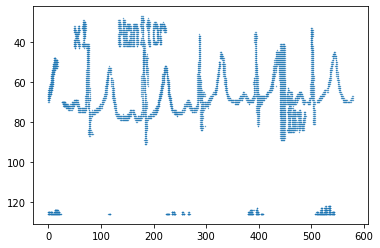

In [24]:
#an example is shown here :
print(inference('/content/im11.jpeg'))

digitize_hr('/content/im11.jpeg')